# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [1]:
# Import required packages
import os
import json
import numpy as np
from collections import defaultdict
# import jsonlines
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [3]:
wiki_datasets, vocab = load_wikitext()

Vocab size: 33175


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [4]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [5]:
wiki_dict = Dictionary(wiki_datasets, include_valid=True)

100%|████████████████████████████████████████████████████████████████████████████| 8464/8464 [00:05<00:00, 1636.09it/s]


In [6]:
for i in range(10):
    print(i, wiki_dict.get_token(i))

0 <bos>
1 <eos>
2 <pad>
3 <unk>
4 Valkyria
5 of
6 the
7 Battlefield
8 3
9 )


In [7]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [8]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [9]:
wiki_tokenized_datasets = tokenize_dataset(wiki_datasets, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][0][0].shape

100%|██████████████████████████████████████████████████████████████████████████| 9708/9708 [00:00<00:00, 315939.66it/s]


torch.Size([1, 31])

In [10]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>')
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [11]:
wiki_loaders = {}

batch_size = 128

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

#### Model + Training (5 pts)

**Early Stopping**

In [12]:
# From: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

**LSTM Model Class**

In [13]:
class LSTMLanguageModel(nn.Module): #RNN is only difference from previous model
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence, h_t, c_t):
        """
        Forward method process the input from token ids to logits
        """
        # [batch_size, sen_length]
        embeddings = self.lookup(encoded_input_sequence)
        # [batch_size, sen_length, embed_length]
        lstm_outputs = self.lstm(embeddings, (h_t, c_t))
        # [batch_size, sen_length, state_dim]
        logits = self.projection(lstm_outputs[0]) #convenient for seq to seq models. check shape of output. lstm gives different
        return logits, lstm_outputs[1]

**Check GPU Availability**

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.3

options = {
    'num_embeddings': len(wiki_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'rnn_dropout': rnn_dropout,
}

model = LSTMLanguageModel(options).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [16]:
def train(model, num_epochs, patience):
    
    plot_cache = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch_number in range(num_epochs):
        
        train_losses = []
        valid_losses = []
        
        model.train()
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            h_0 = torch.zeros(size=(options['num_layers'], inp.shape[0], options['hidden_size'])).to(device)
            c_0 = torch.zeros(size=(options['num_layers'], inp.shape[0], options['hidden_size'])).to(device)
            optimizer.zero_grad()
            inp = inp.to(device)
            target = target.to(device)
            logits, (h_t, c_t) = model(inp, h_0, c_0)
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_loss = sum(train_losses)/len(train_losses)
            

        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(wiki_loaders['valid']):
                h_0 = torch.zeros(size=(options['num_layers'], inp.shape[0], options['hidden_size'])).to(device)
                c_0 = torch.zeros(size=(options['num_layers'], inp.shape[0], options['hidden_size'])).to(device)
                inp = inp.to(device)
                target = target.to(device)
                logits, (h_t, c_t) = model(inp, h_0, c_0)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())      
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        
        plot_cache.append((avg_loss, avg_val_loss))
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            return plot_cache[:-patience]
            break
            
        if (epoch_number + 1) % 5 == 0: 
            print('Validation loss after epoch {}: {:.{prec}f}'.format(epoch_number + 1, avg_val_loss, prec=4))
            print('Training loss after epoch {}: {:.{prec}f}'.format(epoch_number + 1, avg_loss, prec=4))
        
    return plot_cache

In [17]:
plot_cache = train(model, num_epochs=5, patience=2)

Validation loss decreased (inf --> 7.852499).  Saving model ...
Validation loss decreased (7.852499 --> 7.484763).  Saving model ...
Validation loss decreased (7.484763 --> 7.145939).  Saving model ...
Validation loss decreased (7.145939 --> 6.881064).  Saving model ...
Validation loss decreased (6.881064 --> 6.680068).  Saving model ...
Validation loss after epoch 5: 6.6801
Training loss after epoch 5: 6.9498


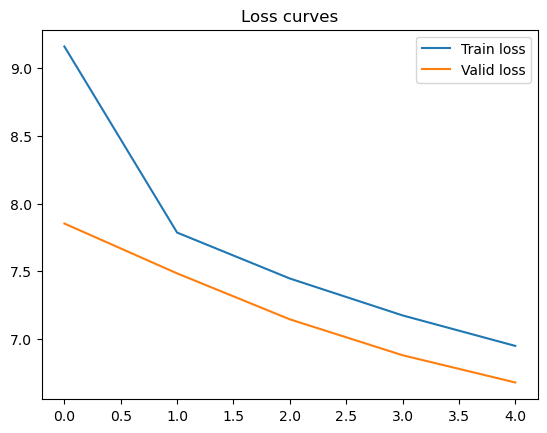

In [18]:
epochs = np.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

#### Performance variation based on hyper-parameter values (5 pts)


Validation loss decreased (inf --> 8.195949).  Saving model ...
Validation loss decreased (8.195949 --> 7.758400).  Saving model ...
Validation loss decreased (7.758400 --> 7.505311).  Saving model ...
Validation loss decreased (7.505311 --> 7.363302).  Saving model ...
Validation loss decreased (7.363302 --> 7.252606).  Saving model ...
Validation loss after epoch 5: 7.2526
Training loss after epoch 5: 7.4520
Validation loss decreased (7.252606 --> 7.111827).  Saving model ...
Validation loss decreased (7.111827 --> 7.021912).  Saving model ...
Validation loss decreased (7.021912 --> 6.944001).  Saving model ...
Validation loss decreased (6.944001 --> 6.895275).  Saving model ...
Validation loss decreased (6.895275 --> 6.854322).  Saving model ...
Validation loss after epoch 10: 6.8543
Training loss after epoch 10: 7.0398
Validation loss decreased (6.854322 --> 6.810843).  Saving model ...
Validation loss decreased (6.810843 --> 6.775890).  Saving model ...
Validation loss decreased (

Validation loss decreased (5.562552 --> 5.557664).  Saving model ...
Validation loss decreased (5.557664 --> 5.551020).  Saving model ...
Validation loss after epoch 50: 5.5510
Training loss after epoch 50: 5.7005
New Best Model... Validation Loss=5.5510 - Hidden Size=128
Validation loss decreased (inf --> 7.856977).  Saving model ...
Validation loss decreased (7.856977 --> 7.488989).  Saving model ...
Validation loss decreased (7.488989 --> 7.164151).  Saving model ...
Validation loss decreased (7.164151 --> 6.903274).  Saving model ...
Validation loss decreased (6.903274 --> 6.694523).  Saving model ...
Validation loss after epoch 5: 6.6945
Training loss after epoch 5: 6.9693
Validation loss decreased (6.694523 --> 6.551280).  Saving model ...
Validation loss decreased (6.551280 --> 6.416549).  Saving model ...
Validation loss decreased (6.416549 --> 6.315810).  Saving model ...
Validation loss decreased (6.315810 --> 6.216402).  Saving model ...
Validation loss decreased (6.216402 -

EarlyStopping counter: 3 out of 3
Early stopping
New Best Model... Validation Loss=5.0904 - Hidden Size=1024


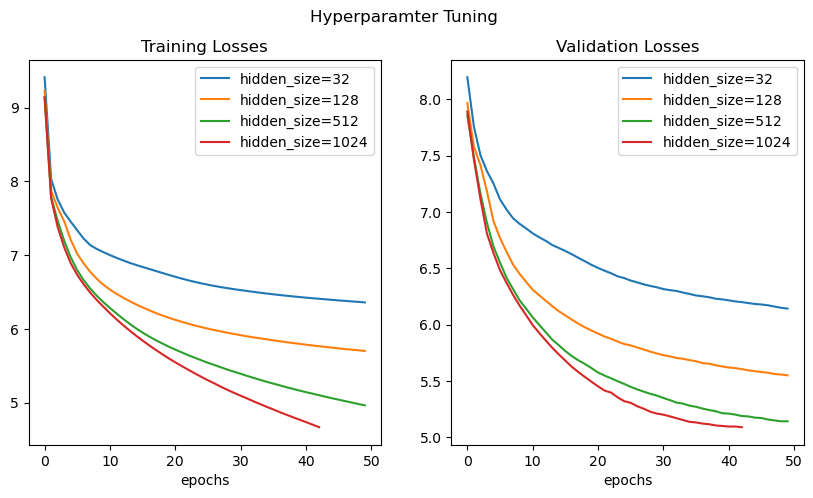

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Hyperparamter Tuning')

axs[0].set_title('Training Losses')
axs[0].set_xlabel('epochs')

axs[1].set_title('Validation Losses')
axs[1].set_xlabel('epochs')

hidden_sizes = [32, 128, 512, 1024]

best_model = None
best_validation = np.inf

performances = [] 

for hidden_size in hidden_sizes:
    options['hidden_size'] = hidden_size

    model = LSTMLanguageModel(options).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)
    
    plot_cache = train(model, num_epochs=50, patience=3)
    
    if plot_cache[-1][-1] < best_validation:
        print('New Best Model... Validation Loss={:.{prec}f} - Hidden Size={}'.format(plot_cache[-1][-1], hidden_size, prec=4))
        best_model = model
        best_validation = plot_cache[-1][-1]
        
    epochs = np.array(list(range(len(plot_cache))))
    
    axs[0].plot(epochs, [i[0] for i in plot_cache], label='hidden_size={}'.format(hidden_size))
    axs[1].plot(epochs, [i[1] for i in plot_cache], label='hidden_size={}'.format(hidden_size))
    
axs[0].legend()
axs[1].legend()
plt.show()

In [20]:
model = best_model

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [21]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\faizg\anaconda3\envs\cds-nlp\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


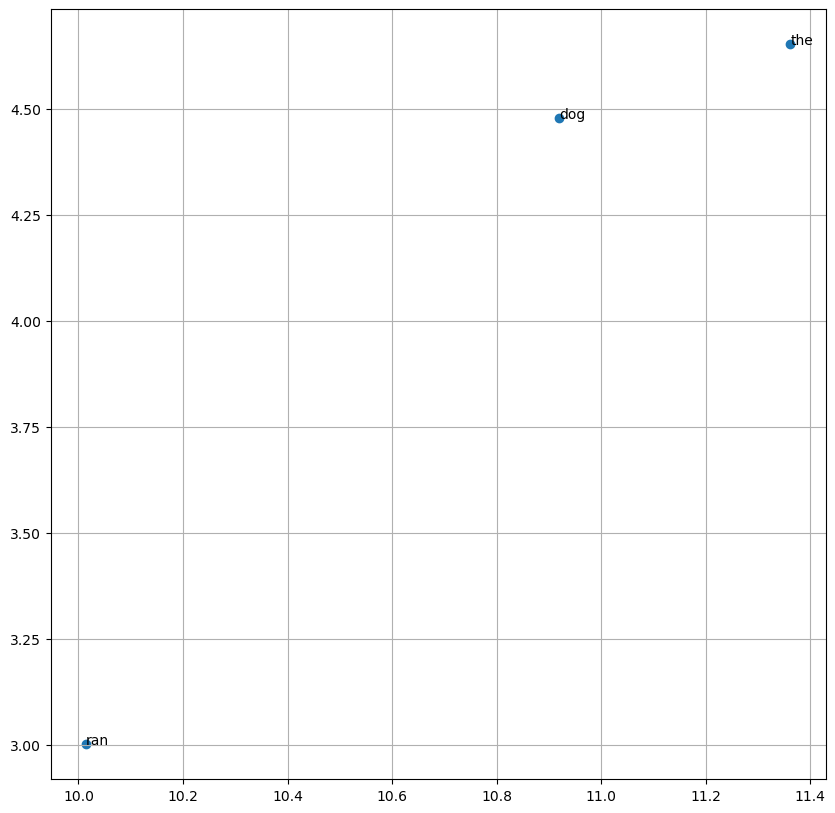

In [22]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### 2.1 Word similarity (3 pts)


In [23]:
def CosineSimilarity(A, B): # form: https://towardsdatascience.com/cosine-similarity-matrix-using-broadcasting-in-python-2b1998ab3ff3
    num = np.dot(A, B.T)
    p1 = np.sqrt(np.sum(A**2, axis=1))[:, None]
    p2 = np.sqrt(np.sum(B**2, axis=1))[None ,:]
    return num / (p1 * p2)

In [24]:
proj_embeddings = model.projection.weight
embeddings_copy = model.projection.weight.clone().cpu().detach().numpy()
similarity_matrix = CosineSimilarity(embeddings_copy, embeddings_copy)

In [25]:
words = ['brother', 'cat', 'hold', 'shirt']
# words = ['run', 'dog', 'where', 'quick']
word_ids = [wiki_dict.get_id(word) for word in words]
word_ids

[4398, 5625, 1171, 5437]

In [26]:
top_indices = []
bot_indices = []

for idx in word_ids:
    sim = similarity_matrix[idx]
    top_indices += np.argsort(sim)[-11:-1].tolist() # highest similarity [-11:-1] to exclude the word itself
    print([wiki_dict.get_token(idx) for idx in np.argsort(sim)[-11:-1].tolist()])
    bot_indices += np.argsort(sim)[0:10].tolist() # highest similarity [-11:-1] to exclude the word itself
    print([wiki_dict.get_token(idx) for idx in np.argsort(sim)[0:10].tolist()])

['friend', 'mother', 'uncle', 'successor', 'grandfather', 'daughter', 'father', 'cousin', 'son', 'wife']
['slopes', 'Loyalsock', 'charts', 'flows', 'beaches', 'westbound', 'Ultratip', 'Delta', 'Baja', 'northeastern']
['acute', 'ylide', 'doctrine', 'tooth', 'hymenium', 'origin', 'embryos', 'god', 'nucleus', 'fox']
['resigned', 'spawned', 'commenced', 'regained', 'enrolled', 'voted', 'sailed', 'surpassed', 'joining', 'dissipating']
['find', 'give', 'allow', 'take', 'continue', 'make', 'serve', 'provide', 'remain', 'leave']
['Trek', 'Stone', 'Single', 'Illustrated', 'Trigger', 'Supporting', 'Angeles', 'prophète', 'Industry', 'Letterman']
['unit', 'rendition', 'loop', 'ability', 'patch', 'disc', 'neck', 'bar', 'dress', 'card']
['DNL', 'Djedkare', 'Echmarcach', 'Egypt', 'Romania', 'Fran', 'Isesi', '1870', 'Ímar', 'Cambodia']


In [27]:
top_words = [wiki_dict.get_token(i) for i in top_indices]
bot_words = [wiki_dict.get_token(i) for i in bot_indices]

#### 2.2 UMAP (3 pts)

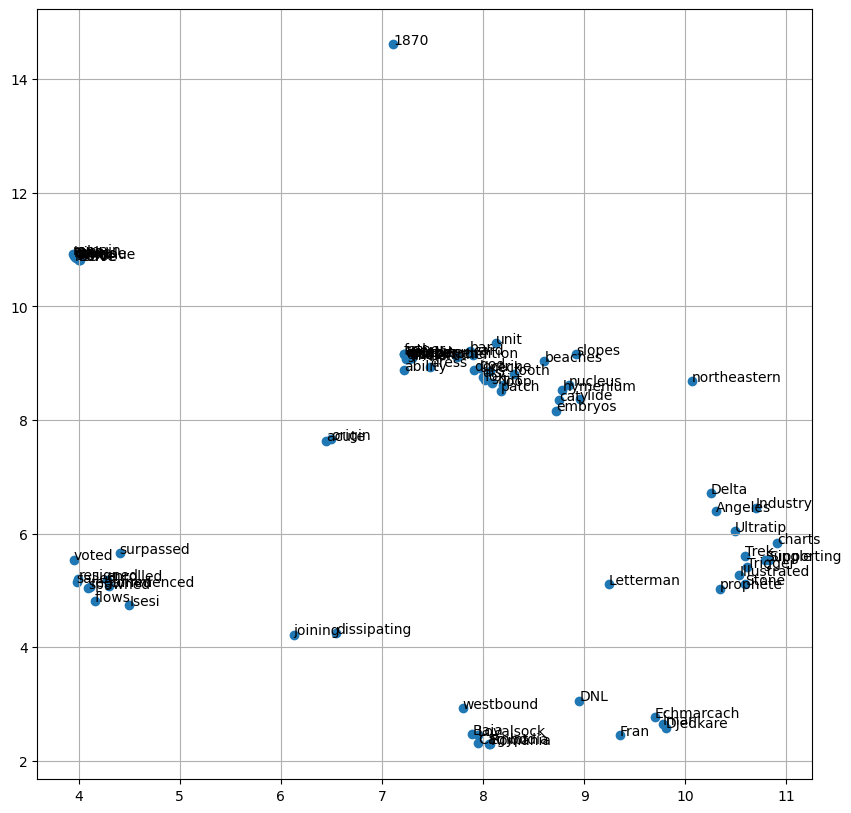

In [28]:
umap_plot(proj_embeddings, word_ids + top_indices + bot_indices, words + top_words + bot_words)

---
### 3 Sampling (14 pts)


#### 3.1 Sampling implementation (4 pts)

In [29]:
num_sampled_seq = 1000

x_0 = torch.tensor([[0]]).to(device)
h_0 = torch.zeros(size=(options['num_layers'], 1, options['hidden_size'])).to(device)
c_0 = torch.zeros(size=(options['num_layers'], 1, options['hidden_size'])).to(device)

tokenized_sentences = []
probabilities = []


for i in range(num_sampled_seq):
    sentence_tokens = []
    prob = 0.0
    j = 0
    while(True):
        if j == 0:
            logits, (h_t, c_t) = model(x_0, h_0, c_0)

        else:
            logits, (h_t, c_t) = model(x_t, h_t, c_t)
        
        p = F.softmax(torch.squeeze(logits, dim=1), dim=1)
        x_t = torch.multinomial(torch.squeeze(p, dim=1), 1)

        prob += torch.log(p.view(p.shape[-1])[x_t.item()]).item()
        
        if x_t.item() == wiki_dict.get_id('<eos>'):
            break
        sentence_tokens.append(x_t.item())
        j += 1
          
    probabilities.append(prob)
    tokenized_sentences.append(sentence_tokens)

#### 3.2 1,000 samples and average log probability implementation (4 pts)

Calculated probabilities when generating the samples

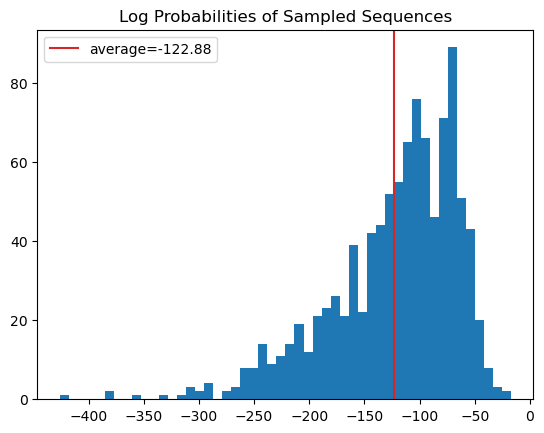

In [30]:
avg_prob = np.mean(probabilities)

plt.hist(probabilities, bins=50)
plt.axvline(avg_prob, color='tab:red', label='average={}'.format(round(avg_prob, 2)))
plt.title('Log Probabilities of Sampled Sequences')
plt.legend()
plt.show()

#### 3.3 Number of unique tokens and sequence length (3 pts)

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


In [31]:
unique_valid = len(set([t for ts in wiki_datasets['valid'][:num_sampled_seq] for t in ts]))
unique_samples = len(set([t for ts in tokenized_sentences for t in ts]))
print('Unique Tokens in Validation Samples: {}'.format(unique_valid))
print('Unique Tokens in Generated Samples: {}'.format(unique_samples))

Unique Tokens in Validation Samples: 4075
Unique Tokens in Generated Samples: 6330


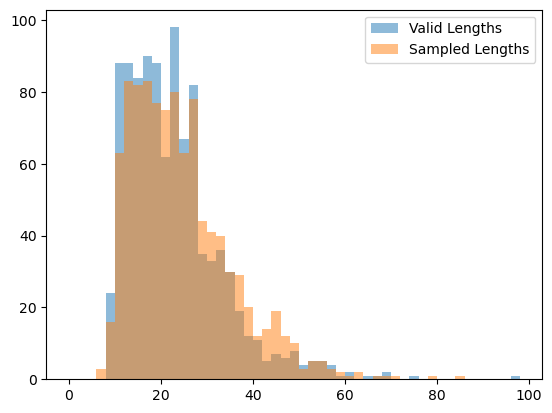

In [32]:
valid_lengths = []
for sample in wiki_datasets['valid'][:num_sampled_seq]:
    valid_lengths.append(len(sample))

generated_samples_lengths = []
for sentence in tokenized_sentences:
    generated_samples_lengths.append(len(sentence))

bins = numpy.linspace(0, max([max(valid_lengths), max(generated_samples_lengths)]), 50)

plt.hist(valid_lengths, bins, alpha=0.5, label='Valid Lengths')
plt.hist(generated_samples_lengths, bins, alpha=0.5, label='Sampled Lengths')

plt.legend()
plt.show()

#### 3.4 Example samples (3 pts)

In [35]:
generated_sentences = [[wiki_dict.get_token(idx) for idx in sen] for sen in tokenized_sentences]
for sentence in generated_sentences[:3]:
    print(" ".join(sentence) + '\n')

As various events , the teams was part of an English choice .

From doing so , this advocate is ingestion and several people to reveal .

On Fu 's ships of the Minnesota State Company , one of the 3rd Battalion 's



The sentences do not look like they are human generated. The sentences are not semantically correct,